In [218]:
# coding=utf-8

# Copyright 2015 and onwards Sanford Ryza, Uri Laserson, Sean Owen and Joshua Wills
#
# See LICENSE file for further information.

# this code assumes you are working from an interactive Thunder (PySpark) shell
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import thunder as td

In [219]:
from pyspark import SparkContext

In [225]:
sc = SparkContext("local[2]", "Analyzing_Neuroimaging _Data_with_PySpark_and _Thunder")

In [289]:
##################
# data exploration
##################

# load some zebrafish brain data
data = td.images.fromtif('tif-stack', engine=sc)

In [297]:
print(type(data))

<class 'thunder.images.images.Images'>


In [295]:
print(data.values._rdd)

PythonRDD[1675] at RDD at PythonRDD.scala:48


In [267]:
# explore the resulting object
print (data)

Images
mode: spark
dtype: uint8
shape: (20, 2, 76, 87)


In [268]:
print (data.values)

BoltArray
mode: spark
shape: (20, 2, 76, 87)



In [269]:
print (data.values.first())

[[[26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 27 27 26]
  ..., 
  [26 26 26 ..., 27 27 26]
  [26 26 26 ..., 27 26 26]
  [25 25 25 ..., 26 26 26]]

 [[25 25 25 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  ..., 
  [26 26 26 ..., 26 26 26]
  [26 26 26 ..., 26 26 26]
  [25 25 25 ..., 26 26 26]]]


In [270]:
print( data.values._rdd)

PythonRDD[828] at RDD at PythonRDD.scala:48


In [271]:
print( data.values._rdd.first())

((0,), array([[[26, 26, 26, ..., 26, 26, 26],
        [26, 26, 26, ..., 26, 26, 26],
        [26, 26, 26, ..., 27, 27, 26],
        ..., 
        [26, 26, 26, ..., 27, 27, 26],
        [26, 26, 26, ..., 27, 26, 26],
        [25, 25, 25, ..., 26, 26, 26]],

       [[25, 25, 25, ..., 26, 26, 26],
        [25, 25, 25, ..., 26, 26, 26],
        [26, 26, 26, ..., 26, 26, 26],
        ..., 
        [26, 26, 26, ..., 26, 26, 26],
        [26, 26, 26, ..., 26, 26, 26],
        [25, 25, 25, ..., 26, 26, 26]]], dtype=uint8))


In [272]:
print (data.shape)

(20, 2, 76, 87)


In [273]:
print (data.count())

20


In [301]:
data.shape

(20, 2, 76, 87)

In [306]:
data.first()[0].shape

(76, 87)

In [305]:
data.first()[1].shape

(76, 87)

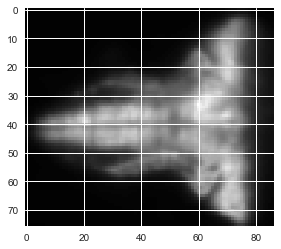

In [309]:
%matplotlib inline 
# plot the raw data
img = data.first()
plt.imshow(img[0, : ,:], interpolation='nearest', aspect='equal', cmap='gray')

(20, 2, 16, 18)


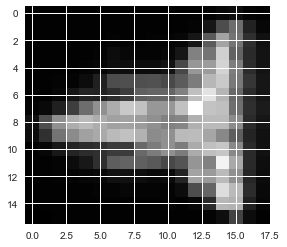

In [318]:
# plot subsampled data
subsampled = data.subsample((1, 5, 5))
plt.imshow(subsampled.first()[0, : ,:], interpolation='nearest', aspect='equal', cmap='gray')
print (subsampled.shape)

In [325]:
# reshuffle data to series representation
series = data.toseries()
print (series.shape)
print (series.index)
print (series.count())
print (series.values._rdd.takeSample(False, 2,2)[0])
print (series.max().values)

(2, 76, 87, 20)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
13224
((0, 62, 59), array([76, 75, 74, 75, 75, 75, 74, 74, 74, 73, 73, 73, 74, 75, 76, 78, 78,
       77, 77, 77], dtype=uint8))
[[[[158 152 145 143 142 141 140 140 139 139 140 140 142 144 153 168 179 185
    185 182]]]]


In [277]:
# distributed computation of stats
stddev = series.map(lambda s: s.std())
print (stddev.values._rdd.take(3))
print (stddev.shape)

[((0, 0, 0), array([ 0.4])), ((0, 0, 1), array([ 0.35707142])), ((0, 0, 2), array([ 0.45825757]))]
(2, 76, 87, 1)


<class 'numpy.ndarray'>
(2, 76, 87)


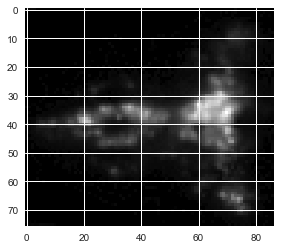

In [310]:
# collecting data locally and repacking it
repacked = stddev.toarray()
plt.imshow(repacked[0,:,:], interpolation='nearest', cmap='gray', aspect='equal')
print (type(repacked))
print (repacked.shape)

Series
mode: spark
dtype: int64
shape: (2, 76, 87, 1)

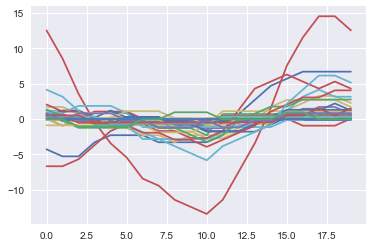

In [279]:
# plot some of the time series themselves
plt.plot(series.center().sample(50).toarray().T)

# distributed computatino of custom statistics
series.map(lambda x: x.argmin())


In [281]:
###############################
# Clustering fish brain regions
###############################

import numpy as np
from pyspark.mllib.clustering import KMeans

images = td.images.frombinary(
    'fish-long', order='F', engine=sc)
series = images.toseries()

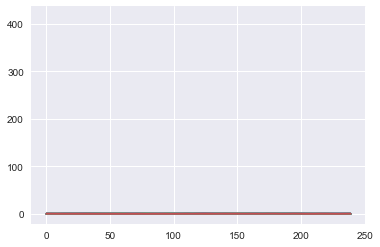

In [282]:
normalized = series.normalize(method='mean')
stddevs = (normalized
    .map(lambda s: s.std())
    .sample(1000))
plt.hist(stddevs.values, bins=20)
plt.plot(
    normalized
        .filter(lambda s: s.std() >= 0.1)
        .sample(50)
        .values.T)

In [283]:
# perform k-means on the normalized series
ks = [5, 10, 15, 20, 30, 50, 100, 200]
models = []
for k in ks:
    models.append(KMeans.train(normalized.values._rdd.values(), k))

In [284]:
# define a couple functions to score the clustering quality
def model_error_1(model):
    def series_error(series):
        cluster_id = model.predict(series)
        center = model.centers[cluster_id]
        diff = center - series
        return diff.dot(diff) ** 0.5

    return (normalized
        .map(series_error)
        .toarray()
        .sum())

def model_error_2(model):
    return model.computeCost(normalized.values._rdd.values())

In [335]:
# compute the error metrics for the different resulting clusterings
errors_1 = np.asarray(map(model_error_1, models))
errors_2 = np.asarray(map(model_error_2, models))

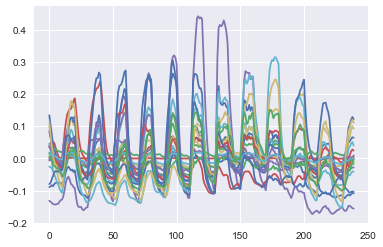

In [285]:
# compute the error metrics for the different resulting clusterings
errors_1 = np.asarray(map(model_error_1, models))
errors_2 = np.asarray(map(model_error_2, models))
#plt.plot(
#    ks, errors_1 / errors_1.sum(), 'k-o',
#    ks, errors_2 / errors_2.sum(), 'b:v')

# plot the best performing model
model20 = models[3]
plt.plot(np.asarray(model20.centers).T)

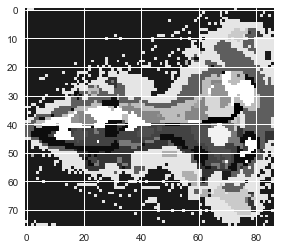

In [312]:
# finally, plot each brain region according to its characteristic behavior
from matplotlib.colors import ListedColormap
cmap_cat = ListedColormap(sns.color_palette("hls", 10), name='from_list')
by_cluster = normalized.map(lambda s: model20.predict(s)).toarray()
plt.imshow(by_cluster[:, :, 0], interpolation='nearest',
    aspect='equal', cmap='gray')
